# Gradient Twitter Analysis Examples

**Author: Newton Campbell** - newtonh20@ieee.org

In this notebook, we demonstrate how to load the offline Twitter data for the summer semester Gradient project into a Python notebook. We then show a couple of examples of cleaning, sentiment analysis and how to form a graph based on semantic similarity of Tweets. Enjoy!

## First, some references
Okay, for those of you who haven't gotten a chance to play with NLP before, we are providing you a list of resources that we hope will be helpful:

#### Libraries and open source resources
* spaCy ([website](https://spacy.io/), [blog](https://explosion.ai/blog)) \[Python; emerging open-source library with [fantastic usage examples](https://spacy.io/usage/spacy-101), [API documentation](https://spacy.io/api), and [demo applications](https://spacy.io/universe)\]
* Natural Language Toolkit (NLTK) ([website](https://www.nltk.org/), [book](https://www.nltk.org/book/)) \[Python; practical intro to programming for NLP, mainly used for teaching\]
* Stanza CoreNLP ([website](https://stanfordnlp.github.io/stanza/)) \[Python; high-quality analysis toolkit\]
* AllenNLP ([website](https://allennlp.org/)) \[Python; NLP research library built on PyTorch\]
* Tensorflow Tutorials ([website](https://www.tensorflow.org/hub/tutorials)) \[Python; Not the first thing folks think about with respect to this kind of NLP. But there are some interesting classification capabilities that may come in handy\]
* R Text Mining Libraries ([website](https://cran.r-project.org/web/views/NaturalLanguageProcessing.html)) \[You read that right; R has tons of open-source libraries that you can use for Text Analysis, [even some that are ports of Python libraries](https://towardsdatascience.com/r-packages-for-text-analysis-ad8d86684adb)\]

#### Oh, and can't forget graph libraries
Ah, let's not forget about graph libraries. You will likely need one for this project. I would give you a list. But the one I would give you is just a subset of the one that [you would find here.](https://wiki.python.org/moin/PythonGraphLibraries). NetworkX and igraph are two of my go-to libraries. They have community detection (clustering for graphs) algorithms and are fairly straightforward to use.


You will also want to play with some of the basic examples that <a href="https://towardsdatascience.com/getting-started-with-natural-language-processing-nlp-2c482420cc05">can be found here</a> and look into the "DIY projects and data sets" section <a href="https://towardsdatascience.com/how-to-get-started-in-nlp-6a62aa4eaeff">at the bottom of this page to really get your feet wet.</a> It can seem a little daunting with just how much there is to know at first. But just try to get a couple of working examples and remember to continue exploring through the semester in tandem to your work.

# Install and import libraries

Let's start by importing some libraries that will help with an analysis of Twitter data

In [2]:
!pip install langdetect
!pip install pycountry
!pip install emoji
!python -m spacy download en_core_web_lg

# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
# This is needed for parsing certain Tweets (You may need to download others for other datasets)
nltk.download('vader_lexicon')
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()           # A more detailed model (with higher-dimension word vectors) - 13s to load, normally 
import networkx as nx                        # a really useful network analysis library
import pycountry
import emoji
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\scardina\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load an Offline Dataset

Now, let's load one of the offline datasets for the project. As stated in the project launch document, you will not have to use the Twitter API for this project. We've downloaded offline versions for you.

**To run this code, you will have to change the value of the offline_tweets variable to the smallest file from Challenge 1:**

In [3]:
# Change this
offline_tweets = 'Challenge1_Small.csv'

offline_tweets_df = pd.read_csv(offline_tweets)
num_tweets = len(offline_tweets_df.index)
display(offline_tweets_df)

,Unnamed: 0,created_at,id,reply_to_id,screen_name,coordinates,place,retweet_count,favorite_count,lang,...,user_loc,user_description,verified,followers_count,friends_count,favourites_count,statuses_count,listed_count,user_created_at,text
0,0,2021-06-04 00:26:48,1400609949244215299,NaN,livingjoyful,NaN,NaN,2,0,en,...,United States,b'#Resistance. #FBR #AntiFascist #BLM\xf0\x9f\...,False,4041,4401,56114,27193,11,2009-06-21 20:45:14,"b""RT @KSTech1: @JoeBiden That is true Mr. Pres..."
1,1,2021-06-04 00:26:40,1400609916096679938,NaN,robjacobs59,NaN,NaN,514,0,en,...,"Nevada, USA",b'Certified Personal Trainer(CPT) National Cou...,False,1304,4284,61516,59569,45,2013-01-28 02:49:03,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
2,2,2021-06-04 00:26:37,1400609903501324301,NaN,RawStory,NaN,NaN,0,1,en,...,"Washington, DC",b'The official Twitter of http://t.co/HJOFeYodXw',True,223173,3937,11292,270682,5007,2008-08-29 12:29:21,b'Joe Manchin: Any infrastructure bill must be...
3,3,2021-06-04 00:26:33,1400609886195666946,NaN,veganjan,NaN,NaN,514,0,en,...,NaN,b'I don\xe2\x80\x99t have as many rights as I ...,False,10,8,4387,854,0,2020-10-30 01:11:33,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
4,4,2021-06-04 00:26:07,1400609778137714690,NaN,ny21MapleMoth,NaN,NaN,514,0,en,...,NaN,b'\xf0\x9f\x8c\x8a blue wave 2022 \xf0\x9f\x8c...,False,79,367,7935,14448,0,2017-07-03 06:19:59,b'RT @PramilaJayapal: We\xe2\x80\x99ve seen th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397,6397,2020-11-16 19:06:23,1328414126356525058,NaN,jonburkeUK,NaN,NaN,61,337,en,...,London,b'Energy \xe2\x9a\xa1\xef\xb8\x8f Waste \xe2\x...,False,21119,1969,28447,101062,314,2012-04-17 10:21:38,"b""\xf0\x9f\x8c\xb3 40% tree canopy cover on-st..."
6398,6398,2020-07-10 10:12:23,1281531709650079744,NaN,jonburkeUK,NaN,NaN,130,753,en,...,London,b'Energy \xe2\x9a\xa1\xef\xb8\x8f Waste \xe2\x...,False,21119,1969,28447,101062,314,2012-04-17 10:21:38,"b""New trees and extra large pits for Mare Stre..."
6399,6399,2020-02-05 18:38:29,1225126564616187905,NaN,jonburkeUK,NaN,NaN,65,221,en,...,London,b'Energy \xe2\x9a\xa1\xef\xb8\x8f Waste \xe2\x...,False,21119,1969,28447,101062,314,2012-04-17 10:21:38,"b""Very excited to announce that Dalston's Colv..."
6400,6400,2019-11-29 17:01:43,1200459837643087872,1.200460e+18,jonburkeUK,NaN,NaN,15,39,en,...,London,b'Energy \xe2\x9a\xa1\xef\xb8\x8f Waste \xe2\x...,False,21119,1969,28447,101062,0,2012-04-17 10:21:38,"b""6/ In particular, I've been heavily influenc..."


## A Little Data Cleaning

To properly evaluate the Tweets' semantic meaning, you usually have to clean up the text a little. Its just easier for most third-party libraries. But you should also see if a third-party library that you're using has its own cleaning function.

**Here, we clean text by using lambda function and clean RT, link, punctuation characters and finally convert to lowercase.**

In [4]:
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("UTF-8").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

offline_tweets_df['text'] = offline_tweets_df['text'].map(lambda x: tweet_cleaner(x))
offline_tweets_df["text"] = offline_tweets_df.text.str.lower()
offline_tweets_df['text']

0       b rt that is true mr president but what seems ...
1       b rt we xe x x ve seen this movie before n nre...
2       b joe manchin any infrastructure bill must be ...
3       b rt we xe x x ve seen this movie before n nre...
4       b rt we xe x x ve seen this movie before n nre...
                              ...                        
6397    b xf x f x c xb tree canopy cover on street an...
6398    b new trees and extra large pits for mare stre...
6399    b very excited to announce that dalston s colv...
6400    b in particular i ve been heavily influenced b...
6401    b what did the administration do about it nwhy...
Name: text, Length: 6402, dtype: object

# Sentiment Analysis

Sentiment Analysis can help us decipher the mood and emotions of general public and gather insightful information regarding the context. Sentiment Analysis is a process of analyzing data and classifying it based on the need of the research. These sentiments can be used for a better understanding of various events and impact caused by it. [L. Bing](https://www.cs.uic.edu/~liub/FBS/SentimentAnalysis-and-OpinionMining.pdf) highlights that in the research literature it is possible to see many different names, e.g. “sentiment analysis, opinion mining, opinion extraction, sentiment mining, subjectivity analysis, affect analysis, emotion analysis, review mining”, however all of them have similar purposes and belong to the subject of sentiment analysis or opinion mining. By analysing these sentiments, we may find what people like, what they want and what their major concerns are.

**Now we have a set of Tweets, loaded into a data frame, that we can mine for various purposes. Next, we will use Textblob to calculate positive, negative, neutral, polarity and compound parameters from the text.**

In [5]:
#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)

positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for index, tweet in offline_tweets_df.iterrows():
 
 #print(tweet.text)
 tweet_list.append(tweet.text)
 analysis = TextBlob(tweet.text)
 score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
 neg = score['neg']
 neu = score['neu']
 pos = score['pos']
 comp = score['compound']
 polarity += analysis.sentiment.polarity
 
 if neg > pos:
  negative_list.append(tweet.text)
  negative += 1
 elif pos > neg:
  positive_list.append(tweet.text)
  positive += 1
 elif pos == neg:
  neutral_list.append(tweet.text)
  neutral += 1

positive = percentage(positive, num_tweets)
negative = percentage(negative, num_tweets)
neutral = percentage(neutral, num_tweets)
polarity = percentage(polarity, num_tweets)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("Total Tweets: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

Total Tweets:  6402
positive number:  3382
negative number:  2050
neutral number:  970


**We can create a straightforward pie chart to profile the data in a more meaningful way:**

In [ ]:
#Creating PieCart
labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for short list of Infrastructure Bill Tweets")
plt.axis('equal')
plt.show()

Users tend to self-identify as Republicans, Democrats, etc. We will add a new column to our data frame called "tweet category" and label based on this identification. **Note that this is intentionally over-simplified and will result in a lot of error:**

In [ ]:


# First, let's establish the Typology dictionary
typology_dict = {'Fringe Left' : -3, 'Progressive' : -2, 'Democrat' : -1, 'Centrist' : 0, 'Libertarian' : 1, 'Republican' : 2, 'Trump-Republican' : 2.5, 'Fringe Right' : 3}

def label_typology (row):
   if pd.isna(row['user_description']):
     return None
   if any(ele in row['user_description'] for ele in ['antifa', 'anarchist']):
      return -3
   if any(ele in row['user_description'] for ele in ['progressive','acab', 'defund the police', 'defundthepolice', 'eattherich','anti-fascist', 'bernie']):
      return -2
   if any(ele in row['user_description'] for ele in ['democrat','liberal','prochoice','pro-choice', 'resistance', 'bidenharris']):
      return -1
   if any(ele in row['user_description'] for ele in ['independent','centrist','moderate']):
      return 0
   if any(ele in row['user_description'] for ele in ['libertarian', 'randpaul']):
      return 1
   if any(ele in row['user_description'] for ele in ['republican','prolife','pro-life', 'nra', '2a']):
      return 2
   if any(ele in row['user_description'] for ele in ['maga', 'kag', 'americafirst', 'America 1st', 'parler', 'build a wall', 'trump2024']):
      return 2.5
   if any(ele in row['user_description'] for ele in ['alex jones', 'alexjones', 'wlm','white lives', '#whitelives', 'infowars', 'evangelical']):
      return 3
   return None

offline_tweets_df['user_description'] = offline_tweets_df['user_description'].str.lower()
offline_tweets_df['tweet category'] = offline_tweets_df.apply (lambda row: label_typology(row), axis=1)

Let's see a quick histogram of our results.

In [ ]:
offline_tweets_df['tweet category'].plot.hist()
plt.xticks([-3,-2,-1,0,1,2,2.5,3], ['Fringe Left', 'Progressive', 'Democrat', 'Centrist', 'Libertarian', 'Republican', 'Trump-Republican', 'Fringe Right'],rotation=90)
plt.show()

**Using the Piper SME Political Typology described in the Project Launch document, let's take a look at this chart for Democrats(ID=-2) and Republicans(ID=2)**

In [ ]:
for group in [typology_dict['Democrat'],typology_dict['Republican']]:
  positive = 0
  negative = 0
  neutral = 0
  polarity = 0
  tweet_list = []
  neutral_list = []
  negative_list = []
  positive_list = []
  rows_in_group = len(offline_tweets_df[offline_tweets_df['tweet category'] == group].index)
  for index, tweet in offline_tweets_df[offline_tweets_df['tweet category'] == group].iterrows():
    #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
      negative_list.append(tweet.text)
      negative += 1
    elif pos > neg:
      positive_list.append(tweet.text)
      positive += 1
    elif pos == neg:
      neutral_list.append(tweet.text)
      neutral += 1

  positive = percentage(positive, rows_in_group)
  negative = percentage(negative, rows_in_group)
  neutral = percentage(neutral, rows_in_group)
  polarity = percentage(polarity, rows_in_group)
  positive = format(positive, '.1f')
  negative = format(negative, '.1f')
  neutral = format(neutral, '.1f')

  #Number of Tweets (Total, Positive, Negative, Neutral)
  tweet_list = pd.DataFrame(tweet_list)
  neutral_list = pd.DataFrame(neutral_list)
  negative_list = pd.DataFrame(negative_list)
  positive_list = pd.DataFrame(positive_list)

  #Creating PieCart
  labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
  sizes = [positive, neutral, negative]
  colors = ['yellowgreen', 'blue','red']
  patches, texts = plt.pie(sizes,colors=colors, startangle=90)
  plt.style.use('default')
  plt.legend(labels)
  plt.title("Sentiment Analysis Results for short list of Infrastructure Bill Tweets: " + list(typology_dict.keys())[list(typology_dict.values()).index(group)])
  plt.axis('equal')
  plt.show()

In this dataset, there seems to be a higher percentage of Negative Tweets about the Infrastructure Bill for the Democrats than for the Republicans. You will see why that is when you scan through the Tweets yourself.

# Some Graph Theory

Here, we will use spaCY to parse the Tweets and get an understanding of how similar they are. Much of this was derived [from this Kaggle example.](https://www.kaggle.com/caractacus/thematic-text-analysis-using-spacy-networkx)

In [34]:
tokens = []
lemma = []
pos = []
parsed_doc = [] 
col_to_parse = 'text'

for doc in nlp.pipe(offline_tweets_df[col_to_parse].astype('unicode').values, batch_size=2000,
                        n_process=3):
    if doc.has_annotation("DEP"):
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc if not n.is_stop])
        lemma.append([n.lemma_ for n in doc if not n.is_stop])
        pos.append([n.pos_ for n in doc if not n.is_stop])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)


offline_tweets_df['parsed_doc'] = parsed_doc
offline_tweets_df['comment_tokens'] = tokens
offline_tweets_df['comment_lemma'] = lemma
offline_tweets_df['pos_pos'] = pos
offline_tweets_df.head()

,Unnamed: 0,created_at,id,reply_to_id,screen_name,coordinates,place,retweet_count,favorite_count,lang,...,friends_count,favourites_count,statuses_count,listed_count,user_created_at,text,parsed_doc,comment_tokens,comment_lemma,pos_pos
0,0,2021-06-04 00:26:48,1400609949244215299,NaN,livingjoyful,NaN,NaN,2,0,en,...,4401,56114,27193,11,2009-06-21 20:45:14,b rt that is true mr president but what seems ...,"(b, rt, that, is, true, mr, president, but, wh...","[b, rt, true, mr, president, presidential, pow...","[b, rt, true, mr, president, presidential, pow...","[X, PROPN, ADJ, PROPN, NOUN, ADJ, NOUN, VERB, ..."
1,1,2021-06-04 00:26:40,1400609916096679938,NaN,robjacobs59,NaN,NaN,514,0,en,...,4284,61516,59569,45,2013-01-28 02:49:03,b rt we xe x x ve seen this movie before n nre...,"(b, rt, we, xe, x, x, ve, seen, this, movie, b...","[b, rt, xe, x, x, ve, seen, movie, n, nrepubli...","[b, rt, xe, x, x, ve, see, movie, n, nrepublic...","[X, PROPN, PROPN, SYM, VERB, AUX, VERB, NOUN, ..."
2,2,2021-06-04 00:26:37,1400609903501324301,NaN,RawStory,NaN,NaN,0,1,en,...,3937,11292,270682,5007,2008-08-29 12:29:21,b joe manchin any infrastructure bill must be ...,"(b, joe, manchin, any, infrastructure, bill, m...","[b, joe, manchin, infrastructure, bill, bipart...","[b, joe, manchin, infrastructure, bill, bipart...","[X, PROPN, NOUN, NOUN, NOUN, ADJ, CCONJ]"
3,3,2021-06-04 00:26:33,1400609886195666946,NaN,veganjan,NaN,NaN,514,0,en,...,8,4387,854,0,2020-10-30 01:11:33,b rt we xe x x ve seen this movie before n nre...,"(b, rt, we, xe, x, x, ve, seen, this, movie, b...","[b, rt, xe, x, x, ve, seen, movie, n, nrepubli...","[b, rt, xe, x, x, ve, see, movie, n, nrepublic...","[X, PROPN, PROPN, SYM, VERB, AUX, VERB, NOUN, ..."
4,4,2021-06-04 00:26:07,1400609778137714690,NaN,ny21MapleMoth,NaN,NaN,514,0,en,...,367,7935,14448,0,2017-07-03 06:19:59,b rt we xe x x ve seen this movie before n nre...,"(b, rt, we, xe, x, x, ve, seen, this, movie, b...","[b, rt, xe, x, x, ve, seen, movie, n, nrepubli...","[b, rt, xe, x, x, ve, see, movie, n, nrepublic...","[X, PROPN, PROPN, SYM, VERB, AUX, VERB, NOUN, ..."


## Remove Stopwords

We can reduce increase the signal:noise ratio in these Tweets by removing some of the more common words (or stopwords). By removing these from the tweets, we would prevent them from influencing the analysis of whether two tweets are similar. 

**For now, let's look at what words are included in spaCy's stopword list.**

In [ ]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stopwords: %d' % len(stop_words))
print(list(stop_words))

In [ ]:
for txt in offline_tweets_df['parsed_doc']:
    txt = []

**Now, let's take a look at spaCy's similarity function:**

In [ ]:
print(offline_tweets_df['parsed_doc'][0].similarity(offline_tweets_df['parsed_doc'][1]))
print(offline_tweets_df['parsed_doc'][0].similarity(offline_tweets_df['parsed_doc'][10]))
print(offline_tweets_df['parsed_doc'][1].similarity(offline_tweets_df['parsed_doc'][10]))

Now, we can form a graph where each node in the graph represents an individual Tweet. And each edge represents similarity. We start out by making the graph fully connected (all nodes connect to other nodes). And then we remove edges that have similarity below a certain threshold (0.95). 

*Sidenote: I quickly grabbed this example from towardsdatascience.com and ran with it to show you the basics. But there is a much, much better way to do this, performance-wise. Can you figure out what it is?*

In [ ]:
# won't scale linearly!                              
# raw_G = nx.Graph() # undirected
# n = 0
# min_wt = 0.95

# for i in offline_tweets_df['parsed_doc']:
#   k = 0
#   for sim in [i.similarity(j) if i != j and not (raw_G.has_edge(j, i)) else 0 for j in offline_tweets_df['parsed_doc']]:
#       if sim > min_wt:
#           raw_G.add_edge(i, offline_tweets_df['parsed_doc'][k], weight = sim)
#           n = n + 1
#       k = k + 1

# print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

In [36]:
vec_array = np.array([doc.vector for doc in offline_tweets_df['parsed_doc']])

In [9]:
vec_array.shape

(6402, 300)

In [10]:
def cosine_sim(X):
    
    norm = (X * X).sum(0, keepdims=True) ** .5
    x_norm = X/norm
    csim = x_norm.T @ x_norm

    return csim

sim_mat = cosine_sim(vec_array.T)

sim_mat.shape

(6402, 6402)

In [23]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

sim_mat2 = 1- pairwise_distances(vec_array, metric='cosine')

In [ ]:
sim_mat2.shape

In [29]:
min_wt = 0.95

sim_mat = np.tril(sim_mat2,-1)
sim_mat = np.fill_diagonal(sim_mat2, 0)
sim_mat = np.where(sim_mat2 >= min_wt, sim_mat2, 0)

In [30]:
sim_mat[:10,:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 1.        ,
        0.95739305, 0.        , 0.95739305, 0.95739305, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.95739305, 0.        , 0.95739305, 0.95739305, 0.        ],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.95739305, 0.        , 0.95739305, 0.95739305, 0.        ],
       [0.        , 0.95739305, 0.        , 0.95739305, 0.95739305,
        0.        , 0.        , 1.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.9999999 ],
       [0.        , 0.95739305, 0.       

In [48]:
# Topological Overlap Matrix function
from scipy.sparse import csr_matrix


def TOMadjacency(AdjMat, threshold_quantile: float = 0.8):
  '''
  TOMadjacency calculates an adjacency matrix by the network overlap of nodes
  in a weighted, undirected graph.
  '''
  # Calculate common neighbors of each node
  L = AdjMat.dot(AdjMat.T)

  # Calculate connectivity of node
  Krow = AdjMat.sum(axis=1)
  Kcol = AdjMat.sum(axis=0)
  Kmin = np.array([np.minimum(k_i, Kcol) for k_i in Krow])

  # Topological overlap
  TOM = (L + AdjMat) / (Kmin + 1 - AdjMat)

  TOM_filtered = np.where(
    TOM >= np.quantile(
      TOM, threshold_quantile), TOM, 0)

  np.fill_diagonal(TOM_filtered, 0)

  TOMlower = np.tril(TOM_filtered)

  TOMsparse = csr_matrix(TOMlower)

  return TOMsparse

In [53]:
tom_adj_mat = TOMadjacency(sim_mat2, threshold_quantile=0.95)

In [54]:
raw_G = nx.from_scipy_sparse_matrix(tom_adj_mat)
print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

6402 nodes, and 1024603 edges created.


Even with such a high threshold, that is a lot of edges.
**Now let's visualize this Graph to see how connected it is:**

In [55]:
print("Nodes: \t\t", raw_G.number_of_nodes())
print("Edges: \t\t", raw_G.number_of_edges())
print("Isolates: \t", nx.number_of_isolates(raw_G))

Nodes: 		 6402
Edges: 		 1024603
Isolates: 	 19


In [56]:
mypos = nx.spring_layout(raw_G)

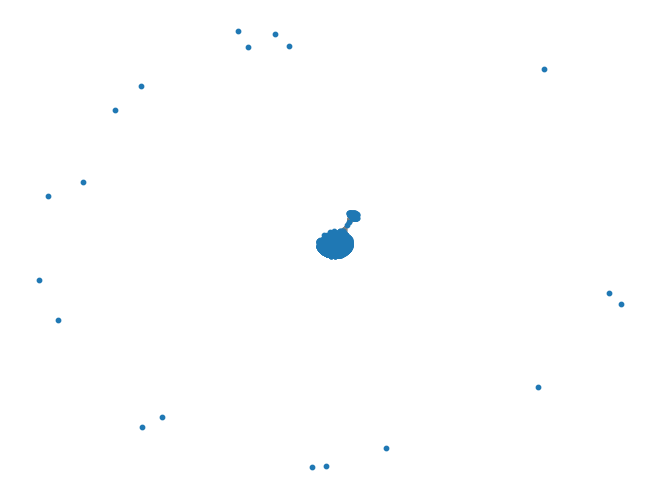

In [57]:
nx.draw(raw_G, node_size=10, pos=mypos, edge_color='gray')
plt.show()

Visualising the whole graph, but only those links of weights above a certain cutoff, allows us to get a feel for a good cutoff level to use when visualising the structure. Having filtered out these lower-weighted links, we can clean up the graph by removing the isolates. This will enable the layout engine to show us more of the structure of the components.

In [58]:
#strong_G = max(nx.connected_components(strong_G), key=len)
Gcc = sorted(nx.connected_components(raw_G), key=len, reverse=True)
strong_G = raw_G.subgraph(Gcc[0])
print(strong_G.number_of_nodes(), "nodes, and", strong_G.number_of_edges(), "edges.")

6383 nodes, and 1024603 edges.


We can also tweak the layout algorithm. By, for example, changing the ideal distance at which the repulsive and attractive forces are in equilibrium. 

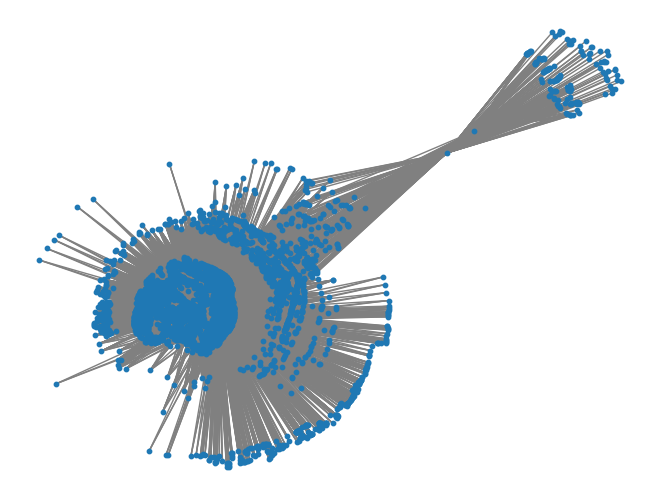

In [61]:
from math import sqrt
count = strong_G.number_of_nodes()
equilibrium = 1 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=50)
nx.draw(strong_G, pos=pos, node_size=10, edge_color='gray')
plt.show()

Let's make communities using the Louvain algorithm:

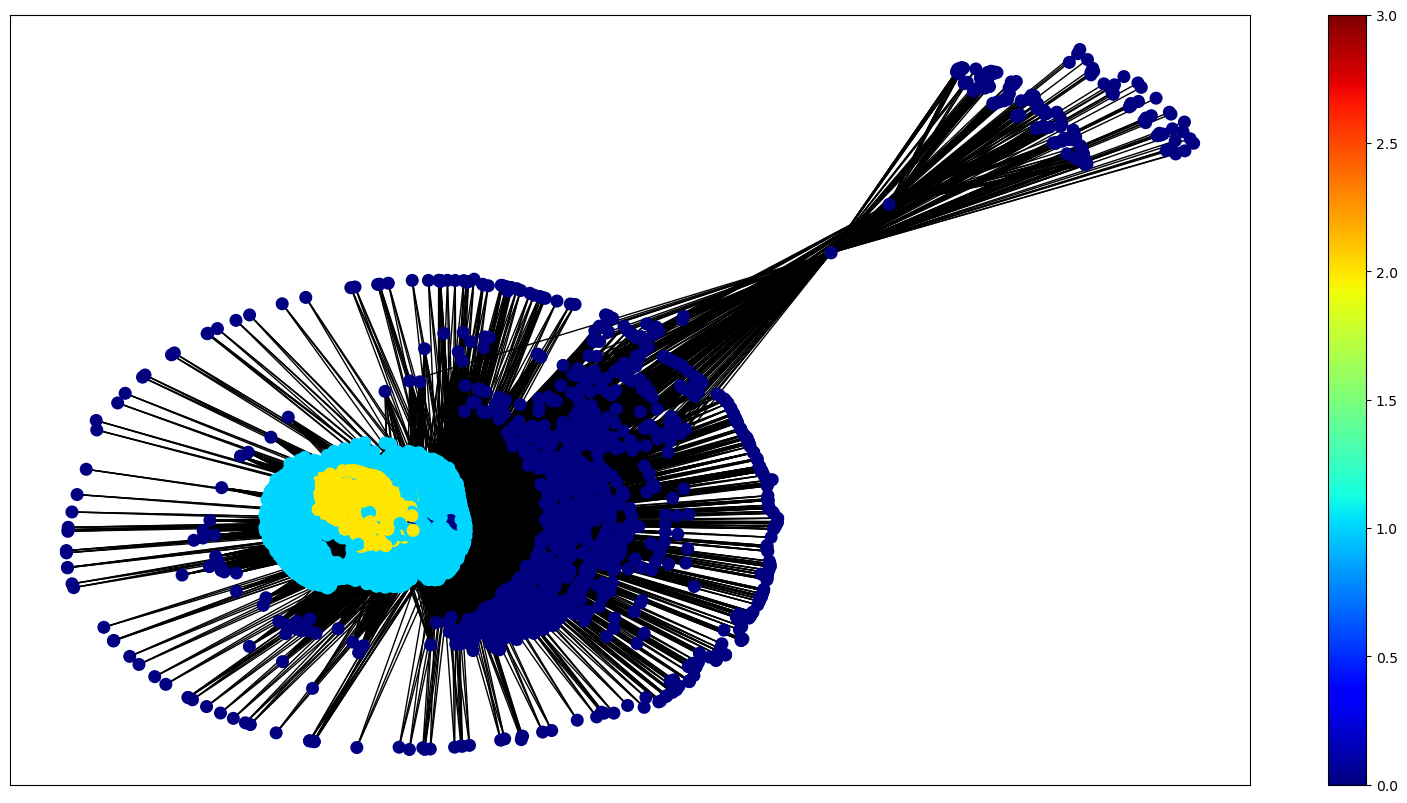

In [62]:
from networkx.algorithms import community
import random
import pandas as pd
import community 
from community import community_louvain

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")
import matplotlib

def simple_Louvain(G):
    """ Louvain method github basic example"""
    partition = community_louvain.best_partition(G)
    # pos = graphviz_layout(G)
    equilibrium = 1 / sqrt(G.number_of_nodes())    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
    pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=50)
    
    max_k_w = []
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys()
                      if partition[nodes] == com]
        max_k_w = max_k_w + [list_nodes]

    
    node_mapping = {}
    map_v = 0
    for node in G.nodes():
        node_mapping[node] = map_v
        map_v += 1

    community_num_group = len(max_k_w)
    color_list_community = [[] for i in range(len(G.nodes()))]
    
    # color
    for i in G.nodes():
        for j in range(community_num_group):
            if i in max_k_w[j]:
                color_list_community[node_mapping[i]] = j
    
    return G, pos, color_list_community, community_num_group, max_k_w

G, pos, color_list_community, community_num_group, max_k_w = simple_Louvain(strong_G)

edges = G.edges()
Feature_color_sub = color_list_community
node_size = 70

fig = plt.figure(figsize=(20, 10))
im = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=Feature_color_sub, cmap='jet', vmin=0, vmax=community_num_group)
nx.draw_networkx_edges(G, pos)
#nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
plt.xticks([])
plt.yticks([])
plt.colorbar(im)
plt.show(block=False)

In [70]:
# remove isolates
# strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

# Community detection methods for weighted acyclic graphs

from cdlib import ensemble
# cdlib requires Python verion at least 3.8.x

from cdlib import algorithms, evaluation
from community import community_louvain

methods = [algorithms.chinesewhispers, algorithms.louvain, algorithms.leiden]

# Chinese whisper parameters
iterations = ensemble.Parameter(name="iterations", start=15, end=25, step=5)
chinese_conf = [iterations]

# Louvain parameters to search
resolution = ensemble.Parameter(name="resolution", start=0.5, end=1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize")
louvain_conf = [resolution, randomize]

# Leiden parameters
leiden_conf = [ensemble.BoolParameter(name='weights', value='weight')]

# Loop through grid search and store best community in a list

comms = []

for coms, scoring in ensemble.pool_grid_filter(strong_G, methods, [chinese_conf, louvain_conf, leiden_conf], quality_score=evaluation.erdos_renyi_modularity, aggregate=max):
    print("%s\nCommunities:\t %s \nConfiguration: %s \nScoring: %s\n" %(coms.method_name, len(coms.communities), coms.method_parameters, scoring))

Chinese Whispers
Communities:	 2 
Configuration: {'weighting': 'top', 'iterations': 15} 
Scoring: FitnessResult(min=None, max=None, score=0.04869091195848537, std=None)



AttributeError: module 'community' has no attribute 'best_partition'